In [1]:
# If you want interactive plots
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
# Change path if necessary, here the cajal repository (direcotry is placed outside the online-neuro) 
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import tensorflow as tf
import pandas as pd

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro import online_learning 
from online_neuro.utils import CustomMinMaxScaler

from trieste.data import Dataset
from trieste.acquisition.function.active_learning import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste import space

from cajal.nrn import Backend as N
from cajal.nrn import SimulationEnvironment
from cajal.nrn.cells import MRG
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn.sources import IsotropicPoint
from cajal.nrn.stimuli import MonophasicPulse
from cajal.units import mm, um, mV, ms, mA, ohm, cm

from simulators.python.problems.cajal_problems import create_mrg
from common.plotting_cajal import (plot_setup_3d, 
                                   plot_progression_AP_2D, 
                                   plot_waveform)

2025-07-03 13:42:22.607976: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 13:42:22.775534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-03 13:42:22.775583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-03 13:42:22.790513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 13:42:22.833777: I tensorflow/core/platform/cpu_feature_guar

numprocs=1


## Single electrode example


In [4]:
# Time resolution
N.dt = 0.005*ms

axon_diameter = 5.7*um # um
axon_nodes = 71 # number of axon nodes
# axon model, by default the central node is at origin of the coordinate system
mrg = MRG(diameter=axon_diameter, axonnodes=axon_nodes) 

# extracellular current source
pointsource = IsotropicPoint(x=0, y=0, z=0.5*mm, rhoe=500*ohm*cm)
stim = MonophasicPulse(amp=-1*mA, pw=0.2*ms, delay=0.5*ms)
electrode = pointsource << stim # Assignment

# simulation environment
env = SimulationEnvironment(axons=[mrg], extra_stim=[electrode])

# calculate threshold
thresh = env.find_thresh()
print(f'Threshold is {thresh:.3f} mA')

#From here on we use create_mrg to create the axon model

Threshold is 0.044 mA


# Two electrodes example

In [5]:
# Create the axon model
mrg = create_mrg(diameter=27, length=120, v_init=-80, verbose=True)

# Here we use a fixed stimulation pulse parameters that we want to block
# The stimulation pulse to block start after 2 ms
stim_amp = -1.00 #* mA
stim_pw = 0.50 #* ms
stim_delay = 2.0 #* ms

# Define blocking parameters
block_amp = 0.8 * mA 
block_pw = 0.50 * ms 
block_delay = 2.0 * ms 

# Create stimuli (a stim and block pulse)
stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

# Create electrodes at both sides of origin (spacing 60 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y=-30 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=30 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors avoid monitoring the edges to eliminate boundary conditions
ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

# Plot the blocking
pointsources = [pointsource_stim, pointsource_block]
labels = ['Stim','Block']


Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


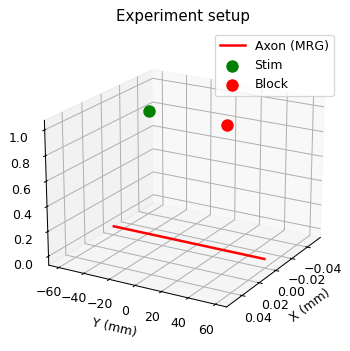

In [6]:
plot_setup_3d(mrg, pointsources, labels,figsize=(4,4), title='Experiment setup',dpi=90)

In [7]:
# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim,
                electrode_block], # You can leave the block out to visualize only stim
    monitors=[
        v_rec,
        ap_monitor_end,
        ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 6 * ms, progressbar=True, early_stopping=False)

5.5 ms: 100%|██████████| 1200/1200 [00:03<00:00, 386.89it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 2
  dt: 0.005 ms

## Visualizing the nerve conduction overt time and space

In [8]:
v_rec.v.shape

(204, 1201)

<Axes: title={'center': 'AP Progression of two pulses'}, xlabel='Time (ms)', ylabel='Node Number'>

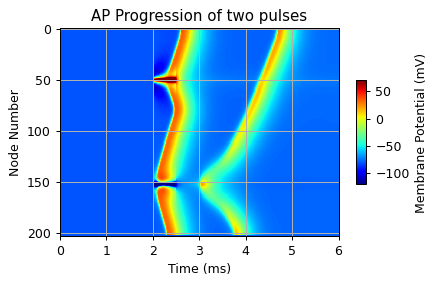

In [9]:
# An example of a failed blocking the AP progression to the right
plot_progression_AP_2D(mrg, v_rec, figsize=(5,3), dpi=90, title="AP Progression of two pulses")

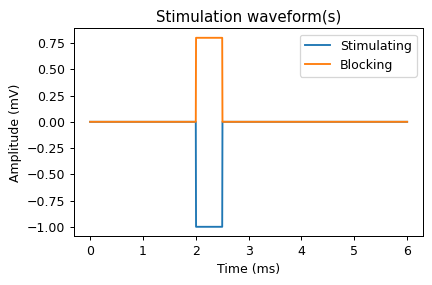

In [10]:
# Replaces the previous plot_stim_and_block
#plot_stim_and_block(stim, block, v_rec, figsize=(4,2), dpi=600)

ax = plot_waveform(stim, v_rec, "Stimulating", figsize=(5,3), dpi=90)
_ = plot_waveform(block, v_rec, "Blocking", ax=ax)



## Performing Gaussian Process based Bayesian Optimization

In [11]:
# These methods checks for action potentials (APs) on both the left and right sides.
from simulators.python.processing.cajal_processing import (get_ap_directional,
                                                           detect_block_naive)


In [12]:
def plot_directional_aps(ap_directional_lines, v_bool, figsize=(8,3)):
    # Plotting (same as v2's plotting)
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(v_bool, aspect='auto', cmap='viridis', origin='upper')
    ax.set_xlabel("Time (pixels)")
    ax.set_ylabel("Node (pixels)")
    ax.set_title("AP Directional Lines")

    colors = ['red', 'deepskyblue', 'lime', 'orange', 'magenta', 'cyan', 'yellow', 'black']
    for i, ap_data in enumerate(ap_directional_lines):
        label_prefix = f'AP {i+1}'
        up_coords = ap_data["upward_line_coords"]
        down_coords = ap_data["downward_line_coords"]
        hull_edges = ap_data['hull_coordinates']
        color_up = colors[i % len(colors)]
        color_down_idx_offset = 3 
        if len(colors) <= color_down_idx_offset: color_down_idx_offset = 1
        color_down = colors[(i + color_down_idx_offset) % len(colors)]
        if color_down == color_up: color_down = colors[(i + color_down_idx_offset + 1) % len(colors)]

        plot_kwargs_up = {'linestyle': '-', 'marker': 'o', 'markersize': 4, 'alpha': 0.9}
        plot_kwargs_down = {'linestyle': '--', 'marker': 'x', 'markersize': 5, 'alpha': 0.9}

        xs, ys = hull_edges[:,1], hull_edges[:,0]
        ax.scatter(xs.tolist(), ys.tolist(), s=4, c='r')
        if up_coords:
            (x1u, y1u), (x2u, y2u) = up_coords
            ax.plot([x1u, x2u], [y1u, y2u], color=color_up, linewidth=2,
                    label=f'{label_prefix} Upward' if i < 3 else None, **plot_kwargs_up)

        if down_coords:
            (x1d, y1d), (x2d, y2d) = down_coords
            ax.plot([x1d, x2d], [y1d, y2d], color=color_down, linewidth=2,
                    label=f'{label_prefix} Downward' if i < 3 else None, **plot_kwargs_down)
        
        if not up_coords and not down_coords: 
                ax.plot(ap_data["component_start_time"], (ap_data["min_y_at_start"] + ap_data["max_y_at_start"])/2, 
                    marker='s', color='gray', markersize=6, linestyle='None',
                    label=f'{label_prefix} Start (No Sig. Y-Prop.)' if i<3 else None)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')
    plt.tight_layout(rect=(0, 0, 0.78, 1))
    plt.show()

    print(f"\nDetected {len(ap_directional_lines)} APs with directional line coordinates (v3):")
    for i, ap_data in enumerate(ap_directional_lines):
        print(f"  AP {i+1} (Label: {ap_data['label']}):")
        print(f"    Component Start Time: {ap_data['component_start_time']}, Overall Component End Time: {ap_data['component_end_time']}")
        print(f"    Initial Y Extent: Min={ap_data['min_y_at_start']}, Max={ap_data['max_y_at_start']}")
        up_line = ap_data['upward_line_coords']
        down_line = ap_data['downward_line_coords']
        
        up_str = 'None (No significant upward propagation detected)'
        if up_line:
            up_str = f"from ({up_line[0][0]},{up_line[0][1]}) to ({up_line[1][0]},{up_line[1][1]}) (Line End Time: {up_line[1][0]})"
        print(f"    Upward Line: {up_str}")
        
        down_str = 'None (No significant downward propagation detected)'
        if down_line:
            down_str = f"from ({down_line[0][0]},{down_line[0][1]}) to ({down_line[1][0]},{down_line[1][1]}) (Line End Time: {down_line[1][0]})"
        print(f"    Downward Line: {down_str}")

In [13]:
def run_simulation(mrg: MRG, 
                   
                   block_amp: float, 
                   block_pw: float, 
                   block_delay: float, 
                   
                   monitoring_nodes: dict[str,int] = {"AP_start":-5, "AP_end": 5},
                   
                   stim_amp: float = -1.00, #* mA
                   stim_pw: float = 0.50, #* ms
                   stim_delay: float = 2.0, #* ms
                   
                   e_sep: float = 60.0, # mm
                   
                   z_pos: float = 1.0, # mm
                   
                   sim_time: float = 6.0, # ms
                   verbose: bool = True) -> dict[str, APMonitor|StateMonitor]:
    """
    Run the AP blocking simulation with given stimulus parameters.
    
    Parameters:
    - stim_amp: Amplitude of the stimulus pulse (mA)
    - stim_pw: Pulse width of the simtulus pulse (ms)
    - stim_delay: Delay of the stimulus pulse (ms)
    
    General assumptions:
    - Electrodes are placed along the axon (y axis by default).
    - X placement is centered at 0 mm (origin).
    - Z placement is the same for both electrodes.
    
    - Medium is isotropic with a fixed resistivity of 500 ohm*cm.
    
    Returns:
    - ap_count: Number of action potentials reaching the end of the axon.
    """

    if verbose:
        print(f"Configuration: Amplitude {block_amp:.2f} mA, Pulse Width {block_pw:.2f} ms, Delay {block_delay:.2f}")

    # Create stimuli
    stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
    block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

    # Create electrodes at both ends (set spacing of electrode_separation mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=-e_sep/2 * mm, z=z_pos * mm, rhoe=500 * ohm * cm)
    pointsource_block = IsotropicPoint(x=0 * mm, y=e_sep/2 * mm, z=z_pos * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    electrode_block = pointsource_block << block

    # Set up monitors
    monitors_dict = dict()
    for key, monitoring_node in monitoring_nodes.items():
        monitor = APMonitor(mrg.node[monitoring_node], threshold= -20 * mV)
        monitors_dict[key] = monitor
    
    v_rec = StateMonitor(mrg.node, "v")
    
    monitors_dict['v_rec'] = v_rec
    # Create the simulation environment
    env = SimulationEnvironment(
        axons=[mrg],
        extra_stim=[electrode_stim, electrode_block],
        monitors= list(monitors_dict.values()) + [v_rec]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(sim_time * ms, early_stopping=False)
    
    return monitors_dict


def nerve_conduction_blocking_objective(mrg, 
                                        block_amp, block_pw, block_delay,
                                        stim_amp= [-1], stim_pw = [0.5], stim_delay=[2],
                                        e_sep = 60
                                        ):
    """
    Objective function to optimize AP blocking
    """
    # TODO improve this part
    if len(block_amp) != len(stim_amp):
        stim_amp = [stim_amp[0]]*len(block_amp)
        stim_pw = [stim_pw[0]]*len(block_amp)
        stim_delay = [stim_delay[0]]*len(block_amp)
        
                    
    #block_amp, block_pw, block_delay = params[:, 0], params[:, 1], params[:, 2]
    
    observations = []
    default_dict = {
        'stim_blocked': np.nan,
        'stim_generated': np.nan
    }
    
    dist_per_node = mrg.length/len(mrg.node)
    ## Based on the rum_simulation, we place stim and block electrodes symmetric to the center
    center_node = int(len(mrg.node)/2) 

    s_node = center_node - int(((e_sep*mm)/2)/dist_per_node)
    b_node = center_node + int(((e_sep*mm)/2)/dist_per_node)

    for s_amp, s_pw, s_delay, b_amp, b_pw, b_delay in zip(stim_amp, stim_pw, stim_delay,
                                                          block_amp, block_pw, block_delay):
        # Run the simulation with given parameters
        try:
            monitors_dict = run_simulation(mrg = mrg,
                                           stim_amp = s_amp,
                                           stim_pw = s_pw,
                                           stim_delay = s_delay,
                                           block_amp = b_amp,
                                           block_pw = b_pw,
                                           block_delay = b_delay,
                                           e_sep = e_sep
                                           )
            
            # observation = nerve_block_condition(monitors_dict["AP_start"],
            #                                     monitors_dict["AP_end"]
            #                                 )
            v_rec = monitors_dict['v_rec']
            
            v_binary = v_rec.v > -0.0 # Assuming some threshold
            
            # ap_lines = get_ap_directional_v2(v_binary,
            #                                  min_nodes_for_ap_start=1,
            #                                  y_propagation_threshold=10)
            
            ap_lines = get_ap_directional(v_binary, min_nodes_for_ap_start=1, y_propagation_threshold=10)
            

            # ap_evaluation = detect_block(stim_delay=s_delay,
            #                              ap_directional_lines=ap_lines,
            #                              v_rec = v_rec,
            #                              block_position = 'downward')
            ap_evaluation = detect_block_naive(stim_delay=s_delay,
                                                ap_directional_lines=ap_lines,
                                                v_rec = v_rec,
                                                block_position = 'downward')
            
            print("   ")
            plot_directional_aps(ap_directional_lines=ap_lines, v_bool=v_binary)
            print(ap_evaluation)
            
            observations.append(ap_evaluation)

        except Exception as e:
            print(e)
            print(f"Simulation failed with amp={b_amp}, pulse width={b_pw}, delay={b_delay}: {e}")
            observations.append(default_dict)  

    return observations #np.array(observations).reshape(-1, 1)


In [14]:
from scipy.spatial import ConvexHull
from scipy import ndimage

def get_ap_directional(binary_array, min_nodes_for_ap_start=1, y_propagation_threshold=1):
    """
    Identifies APs and provides line coordinates for "upward" propagation from its
    initial min-y extent and "downward" propagation from its initial max-y extent.
    Lines are only generated if significant y-propagation occurs in that direction.
    Lines extend to the end of any plateau at the maximum y-excursion for that specific front's envelope.

    Args:
        binary_array (np.array): 2D boolean or int (0/1) array.
        min_nodes_for_ap_start (int): Minimum y-span at AP start.
        y_propagation_threshold (int): Min change in y for propagation to be considered significant.

    Returns:
        list: Dictionaries for each AP:
            - 'label', 'component_start_time', 'component_end_time' (overall component)
            - 'y_span_at_start', 'min_y_at_start', 'max_y_at_start'
            - 'upward_line_coords' (tuple of tuples or None): ((x_start, y_start_min), (x_end_up_plateau, y_extreme_of_min_envelope))
            - 'downward_line_coords' (tuple of tuples or None): ((x_start, y_start_max), (x_end_down_plateau, y_extreme_of_max_envelope))
    """
    if not isinstance(binary_array, np.ndarray) or binary_array.ndim != 2:
        raise ValueError("binary_array must be a 2D NumPy array.")
    
    if binary_array.dtype == bool:
        binary_array = binary_array.astype(np.int8)

    labeled_array, num_features = ndimage.label(binary_array)
    if num_features == 0: return []

    detected_ap_lines_data = []

    for label_idx in range(1, num_features + 1):
        coords_comp = np.argwhere(labeled_array == label_idx)
        if coords_comp.shape[0] == 0: continue
        
        if coords_comp.shape[0] < 3:
            continue
        
        hull = ConvexHull(coords_comp)
        hull_coords = coords_comp[hull.vertices]
        
        t_start_comp = np.min(coords_comp[:, 1])
        t_end_comp_overall = np.max(coords_comp[:, 1])

        y_nodes_at_t_start_arr = np.unique(coords_comp[coords_comp[:, 1] == t_start_comp, 0])
        y_span_at_start = len(y_nodes_at_t_start_arr)

        if y_span_at_start < min_nodes_for_ap_start: continue

        min_y_at_start = np.min(y_nodes_at_t_start_arr)
        max_y_at_start = np.max(y_nodes_at_t_start_arr)

        min_y_envelope_points = []
        max_y_envelope_points = []
        
        for t_current in range(t_start_comp, t_end_comp_overall + 1):
            y_nodes_at_t_current = np.unique(coords_comp[coords_comp[:, 1] == t_current, 0])
            if y_nodes_at_t_current.size > 0:
                min_y_envelope_points.append((t_current, np.min(y_nodes_at_t_current)))
                max_y_envelope_points.append((t_current, np.max(y_nodes_at_t_current)))
        
        upward_line_coords = None
        downward_line_coords = None

        # Determine Upward Line
        if min_y_envelope_points:
            # Find the most extreme y-value achieved by the min_y_envelope itself
            y_extreme_min_of_min_envelope = min(y_val for t, y_val in min_y_envelope_points)
            
            propagated_upward_significantly = (y_extreme_min_of_min_envelope < min_y_at_start - y_propagation_threshold)
            
            if propagated_upward_significantly:
                # Find the last time this extreme y-value was achieved by the min_y_envelope
                t_end_plateau_up = t_start_comp 
                for t_env, y_env in reversed(min_y_envelope_points):
                    if y_env == y_extreme_min_of_min_envelope:
                        t_end_plateau_up = t_env
                        break
                upward_line_coords = ((t_start_comp, min_y_at_start), (t_end_plateau_up, y_extreme_min_of_min_envelope))
                
        # Determine Downward Line
        if max_y_envelope_points:
            # Find the most extreme y-value achieved by the max_y_envelope itself
            y_extreme_max_of_max_envelope = max(y_val for t, y_val in max_y_envelope_points)

            propagated_downward_significantly = (y_extreme_max_of_max_envelope > max_y_at_start + y_propagation_threshold)

            if propagated_downward_significantly:
                # Find the last time this extreme y-value was achieved by the max_y_envelope
                t_end_plateau_down = t_start_comp
                for t_env, y_env in reversed(max_y_envelope_points):
                    if y_env == y_extreme_max_of_max_envelope:
                        t_end_plateau_down = t_env
                        break
                downward_line_coords = ((t_start_comp, max_y_at_start), (t_end_plateau_down, y_extreme_max_of_max_envelope))
        
        detected_ap_lines_data.append({
            "label": label_idx,
            "total_of_features": num_features,
            "hull_coordinates": hull_coords,
            "component_start_time": t_start_comp,
            "component_end_time": t_end_comp_overall, 
            "upward_line_coords": upward_line_coords,
            "downward_line_coords": downward_line_coords,
            "y_span_at_start": y_span_at_start,
            "min_y_at_start": min_y_at_start,
            "max_y_at_start": max_y_at_start,
        })

    detected_ap_lines_data.sort(key=lambda ap: ap["component_start_time"])
    return detected_ap_lines_data

In [15]:
# Define parameter bounds
lb = [-4.00, 0.05, 0.05]  # Lower bounds for [block_amp, block_pw, block_delay]
ub = [4.00, 3.00, 3]  # Upper bounds

# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, 
                            feature_max=ub,
                            output_range=(-1, 1))

# Define search space
search_space = space.Box(lower=[-1, -1, -1], upper=[1, 1, 1])

# Generate initial amount of samples 
init_samples = 30
qp_minmax = search_space.sample(init_samples).numpy()
qp = scaler.inverse_transform(qp_minmax)

# Set desired diameter, length and v_init
mrg = create_mrg(diameter=27,
                 length=120, 
                 v_init=-80, 
                 verbose=True)

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


Configuration: Amplitude -1.20 mA, Pulse Width 2.01 ms, Delay 0.49


5.5 ms: 100%|██████████| 1200/1200 [00:06<00:00, 189.93it/s]


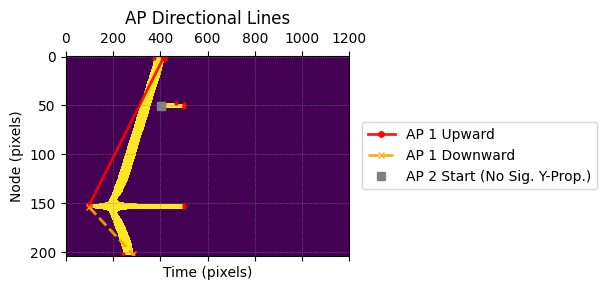


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 99, Overall Component End Time: 500
    Initial Y Extent: Min=152, Max=154
    Upward Line: from (99,152) to (414,1) (Line End Time: 414)
    Downward Line: from (99,154) to (284,202) (Line End Time: 284)
  AP 2 (Label: 2):
    Component Start Time: 401, Overall Component End Time: 502
    Initial Y Extent: Min=50, Max=51
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude -1.84 mA, Pulse Width 2.77 ms, Delay 2.31


5.5 ms: 100%|██████████| 1200/1200 [00:05<00:00, 201.58it/s]


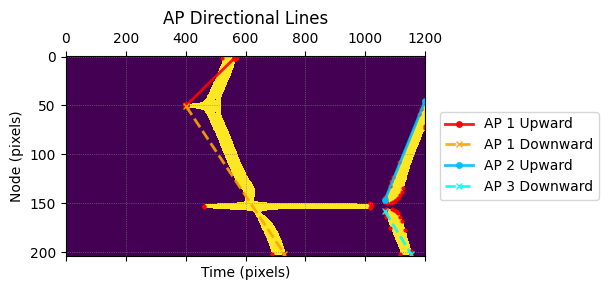


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 1020
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (730,202) (Line End Time: 730)
  AP 2 (Label: 2):
    Component Start Time: 1065, Overall Component End Time: 1200
    Initial Y Extent: Min=147, Max=147
    Upward Line: from (1065,147) to (1200,45) (Line End Time: 1200)
    Downward Line: None (No significant downward propagation detected)
  AP 3 (Label: 3):
    Component Start Time: 1065, Overall Component End Time: 1153
    Initial Y Extent: Min=158, Max=158
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (1065,158) to (1153,202) (Line End Time: 1153)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 2}}
Configuration: Amplitude 0.02 mA, Pulse Width 2.97 ms, Delay 1.1

5.5 ms: 100%|██████████| 1200/1200 [00:06<00:00, 192.68it/s]


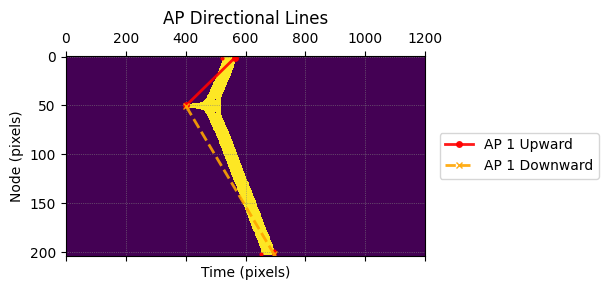


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 695
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (695,202) (Line End Time: 695)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude -2.56 mA, Pulse Width 0.39 ms, Delay 2.02


5.5 ms: 100%|██████████| 1200/1200 [00:06<00:00, 196.09it/s]


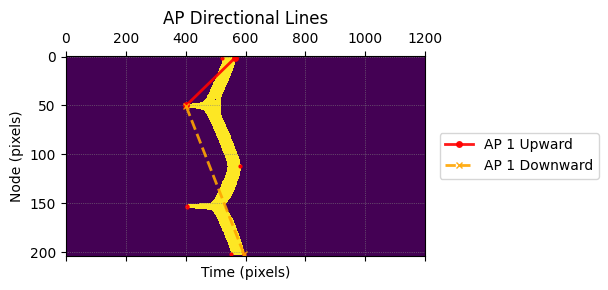


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 595
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (566,1) (Line End Time: 566)
    Downward Line: from (402,51) to (595,202) (Line End Time: 595)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 3.87 mA, Pulse Width 1.11 ms, Delay 2.67


5.5 ms: 100%|██████████| 1200/1200 [00:06<00:00, 198.76it/s]


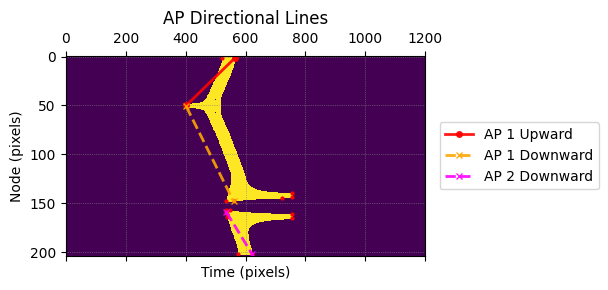


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 756
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (566,1) (Line End Time: 566)
    Downward Line: from (402,51) to (560,148) (Line End Time: 560)
  AP 2 (Label: 2):
    Component Start Time: 536, Overall Component End Time: 756
    Initial Y Extent: Min=157, Max=159
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (536,159) to (622,202) (Line End Time: 622)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 2.72 mA, Pulse Width 2.83 ms, Delay 2.16


5.5 ms: 100%|██████████| 1200/1200 [00:05<00:00, 203.82it/s]


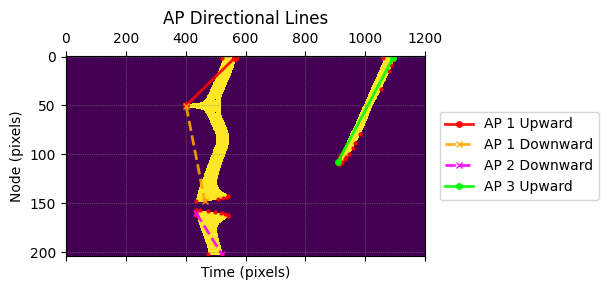


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 565
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (464,148) (Line End Time: 464)
  AP 2 (Label: 3):
    Component Start Time: 435, Overall Component End Time: 542
    Initial Y Extent: Min=158, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (435,160) to (521,202) (Line End Time: 521)
  AP 3 (Label: 2):
    Component Start Time: 908, Overall Component End Time: 1093
    Initial Y Extent: Min=108, Max=110
    Upward Line: from (908,108) to (1093,1) (Line End Time: 1093)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 2, 'blockside_aps': 2}}
Configuration: Amplitude -0.23 mA, Pulse Width 2.29 ms, Delay 1.89


5.5 ms: 100%|██████████| 1200/1200 [00:06<00:00, 193.87it/s]


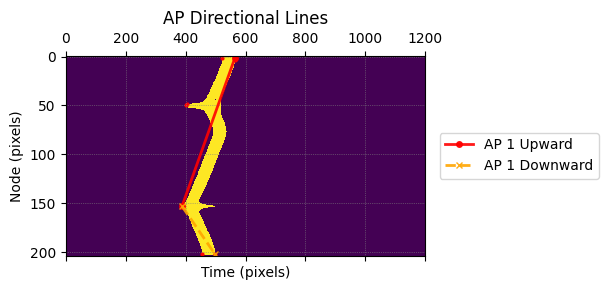


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 388, Overall Component End Time: 565
    Initial Y Extent: Min=153, Max=153
    Upward Line: from (388,153) to (565,1) (Line End Time: 565)
    Downward Line: from (388,153) to (498,202) (Line End Time: 498)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 1.77 mA, Pulse Width 1.81 ms, Delay 1.08


5.5 ms: 100%|██████████| 1200/1200 [00:06<00:00, 183.60it/s]


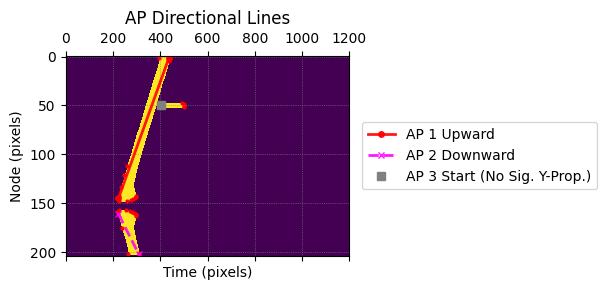


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 223, Overall Component End Time: 437
    Initial Y Extent: Min=145, Max=147
    Upward Line: from (223,145) to (437,1) (Line End Time: 437)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 3):
    Component Start Time: 223, Overall Component End Time: 309
    Initial Y Extent: Min=158, Max=161
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (223,161) to (309,202) (Line End Time: 309)
  AP 3 (Label: 2):
    Component Start Time: 401, Overall Component End Time: 502
    Initial Y Extent: Min=49, Max=51
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 2.61 mA, Pulse Width 2.83 ms, Delay 0.79


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 141.54it/s]


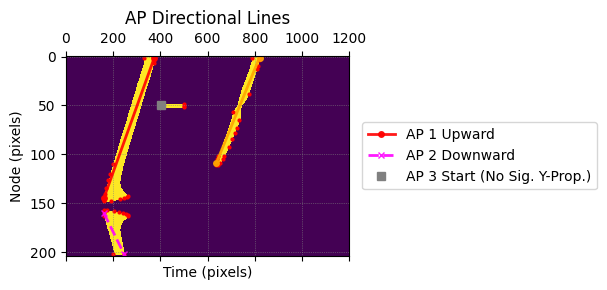


Detected 4 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 161, Overall Component End Time: 375
    Initial Y Extent: Min=145, Max=147
    Upward Line: from (161,145) to (375,1) (Line End Time: 375)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 4):
    Component Start Time: 161, Overall Component End Time: 263
    Initial Y Extent: Min=158, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (161,160) to (247,202) (Line End Time: 247)
  AP 3 (Label: 3):
    Component Start Time: 402, Overall Component End Time: 502
    Initial Y Extent: Min=49, Max=51
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
  AP 4 (Label: 2):
    Component Start Time: 637, Overall Component End Time: 820
    Initial Y Extent: Min=109, Max=111
    Upward Line: from (637,109) to (820,1) (Line End T

5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 144.79it/s]


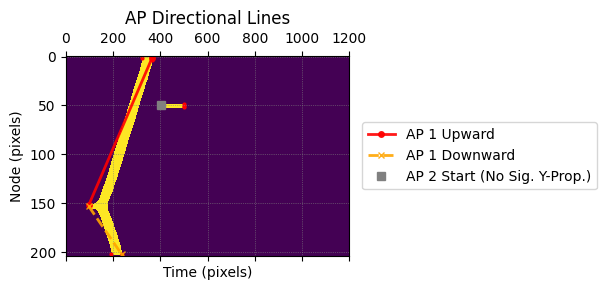


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 97, Overall Component End Time: 366
    Initial Y Extent: Min=152, Max=153
    Upward Line: from (97,152) to (366,1) (Line End Time: 366)
    Downward Line: from (97,153) to (236,202) (Line End Time: 236)
  AP 2 (Label: 2):
    Component Start Time: 402, Overall Component End Time: 502
    Initial Y Extent: Min=49, Max=51
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 3.20 mA, Pulse Width 2.22 ms, Delay 1.59


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 133.64it/s]


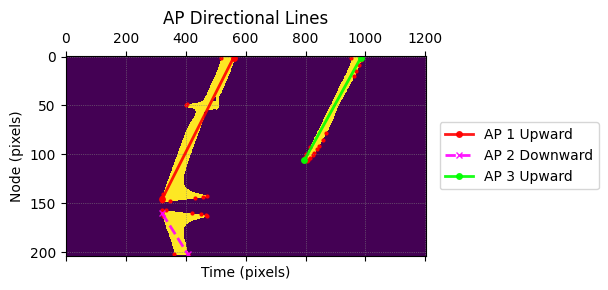


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 321, Overall Component End Time: 560
    Initial Y Extent: Min=146, Max=148
    Upward Line: from (321,146) to (560,1) (Line End Time: 560)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 3):
    Component Start Time: 321, Overall Component End Time: 472
    Initial Y Extent: Min=158, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (321,160) to (407,202) (Line End Time: 407)
  AP 3 (Label: 2):
    Component Start Time: 796, Overall Component End Time: 985
    Initial Y Extent: Min=106, Max=107
    Upward Line: from (796,106) to (985,1) (Line End Time: 985)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 2, 'blockside_aps': 2}}
Configuration: Amplitude 2.78 mA, Pulse Width 2.09 ms, Delay 1.24


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 141.59it/s]


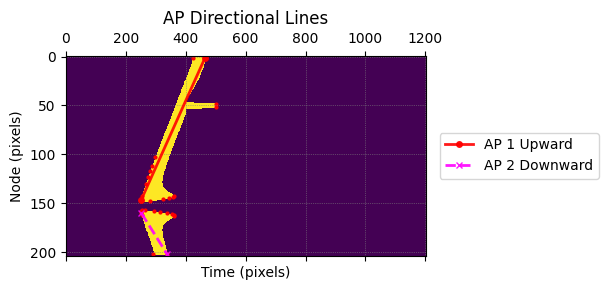


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 251, Overall Component End Time: 502
    Initial Y Extent: Min=147, Max=147
    Upward Line: from (251,147) to (465,1) (Line End Time: 465)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 2):
    Component Start Time: 252, Overall Component End Time: 362
    Initial Y Extent: Min=158, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (252,160) to (338,202) (Line End Time: 338)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 2}}
Configuration: Amplitude 2.84 mA, Pulse Width 2.72 ms, Delay 2.86


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 138.64it/s]


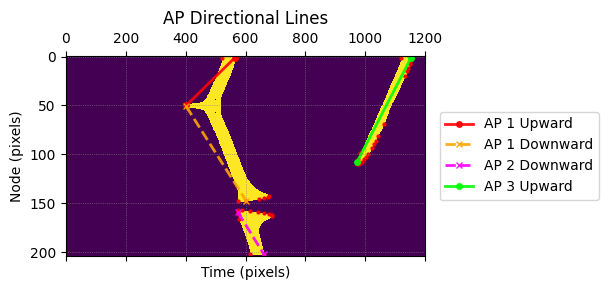


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 680
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (603,148) (Line End Time: 603)
  AP 2 (Label: 3):
    Component Start Time: 574, Overall Component End Time: 688
    Initial Y Extent: Min=158, Max=159
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (574,159) to (661,202) (Line End Time: 661)
  AP 3 (Label: 2):
    Component Start Time: 972, Overall Component End Time: 1153
    Initial Y Extent: Min=108, Max=110
    Upward Line: from (972,108) to (1153,1) (Line End Time: 1153)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 2, 'blockside_aps': 2}}
Configuration: Amplitude 1.97 mA, Pulse Width 2.45 ms, Delay 0.25


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 142.95it/s]


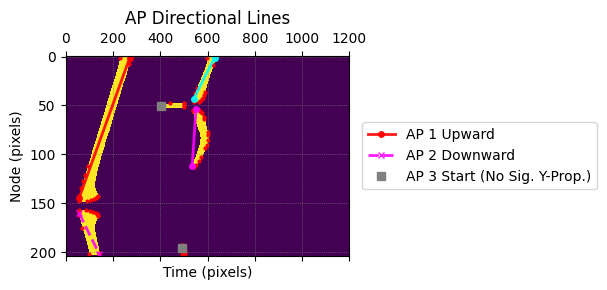


Detected 6 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 56, Overall Component End Time: 271
    Initial Y Extent: Min=145, Max=147
    Upward Line: from (56,145) to (271,1) (Line End Time: 271)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 5):
    Component Start Time: 56, Overall Component End Time: 142
    Initial Y Extent: Min=158, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (56,160) to (142,202) (Line End Time: 142)
  AP 3 (Label: 3):
    Component Start Time: 402, Overall Component End Time: 502
    Initial Y Extent: Min=50, Max=51
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
  AP 4 (Label: 6):
    Component Start Time: 490, Overall Component End Time: 506
    Initial Y Extent: Min=194, Max=197
    Upward Line: None (No significant upward propagation d

5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 144.34it/s]


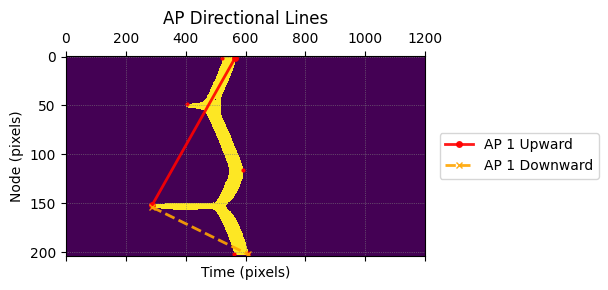


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 288, Overall Component End Time: 607
    Initial Y Extent: Min=152, Max=154
    Upward Line: from (288,152) to (566,1) (Line End Time: 566)
    Downward Line: from (288,154) to (607,202) (Line End Time: 607)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 3.73 mA, Pulse Width 0.23 ms, Delay 1.22


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 140.23it/s]


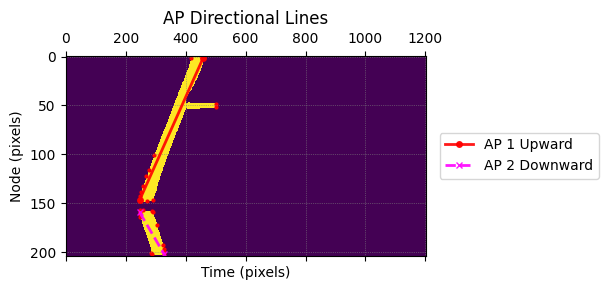


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 246, Overall Component End Time: 502
    Initial Y Extent: Min=147, Max=148
    Upward Line: from (246,147) to (459,1) (Line End Time: 459)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 2):
    Component Start Time: 246, Overall Component End Time: 328
    Initial Y Extent: Min=157, Max=159
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (246,159) to (328,202) (Line End Time: 328)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude -3.81 mA, Pulse Width 2.80 ms, Delay 2.05


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 147.86it/s]


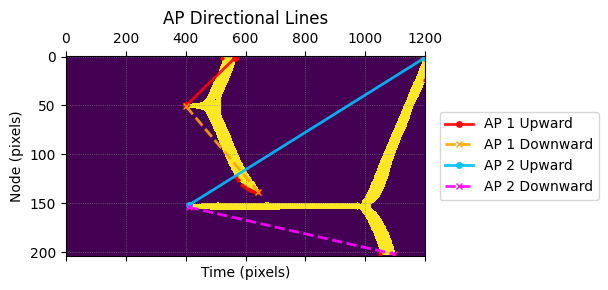


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 644
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (566,1) (Line End Time: 566)
    Downward Line: from (402,51) to (642,138) (Line End Time: 642)
  AP 2 (Label: 2):
    Component Start Time: 410, Overall Component End Time: 1200
    Initial Y Extent: Min=152, Max=154
    Upward Line: from (410,152) to (1200,1) (Line End Time: 1200)
    Downward Line: from (410,154) to (1096,202) (Line End Time: 1096)
{'stim_generated': True, 'stim_blocked': True, 'debug_info': {'num_aps_gen_side': 2, 'blockside_aps': 1}}
Configuration: Amplitude 3.06 mA, Pulse Width 0.41 ms, Delay 2.43


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 141.59it/s]


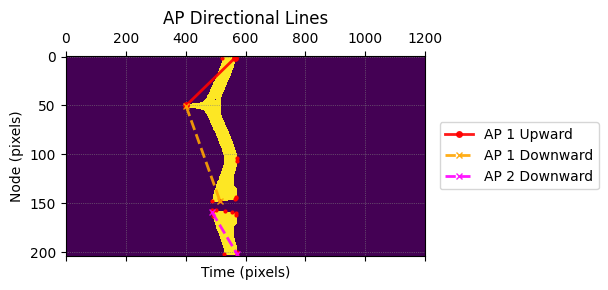


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 571
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (566,1) (Line End Time: 566)
    Downward Line: from (402,51) to (515,148) (Line End Time: 515)
  AP 2 (Label: 2):
    Component Start Time: 488, Overall Component End Time: 572
    Initial Y Extent: Min=158, Max=159
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (488,159) to (572,202) (Line End Time: 572)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 0.77 mA, Pulse Width 1.52 ms, Delay 1.02


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 142.21it/s]


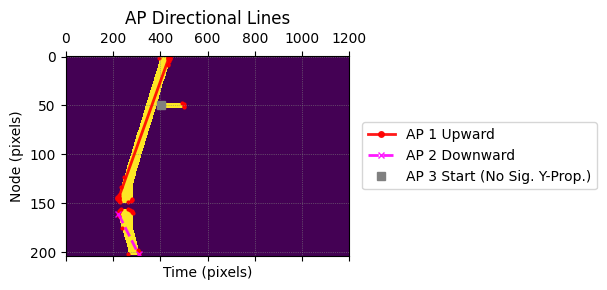


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 223, Overall Component End Time: 437
    Initial Y Extent: Min=145, Max=145
    Upward Line: from (223,145) to (437,1) (Line End Time: 437)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 3):
    Component Start Time: 223, Overall Component End Time: 308
    Initial Y Extent: Min=161, Max=161
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (223,161) to (308,202) (Line End Time: 308)
  AP 3 (Label: 2):
    Component Start Time: 401, Overall Component End Time: 502
    Initial Y Extent: Min=49, Max=51
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude -2.34 mA, Pulse Width 2.29 ms, Delay 1.98


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 143.60it/s]


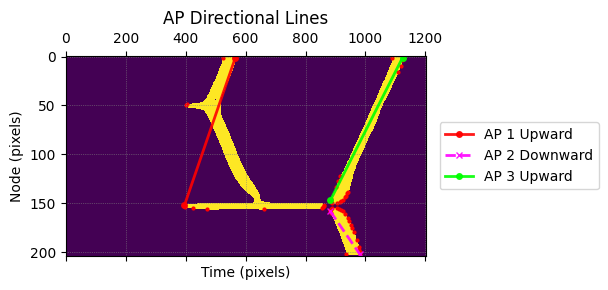


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 396, Overall Component End Time: 860
    Initial Y Extent: Min=152, Max=153
    Upward Line: from (396,152) to (566,1) (Line End Time: 566)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 3):
    Component Start Time: 882, Overall Component End Time: 981
    Initial Y Extent: Min=157, Max=158
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (882,158) to (981,202) (Line End Time: 981)
  AP 3 (Label: 2):
    Component Start Time: 883, Overall Component End Time: 1124
    Initial Y Extent: Min=147, Max=148
    Upward Line: from (883,147) to (1124,1) (Line End Time: 1124)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': True, 'debug_info': {'num_aps_gen_side': 2, 'blockside_aps': 1}}
Configuration: Amplitude 1.27 mA, Pulse Width 0.15 ms, Delay 2.26


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 145.08it/s]


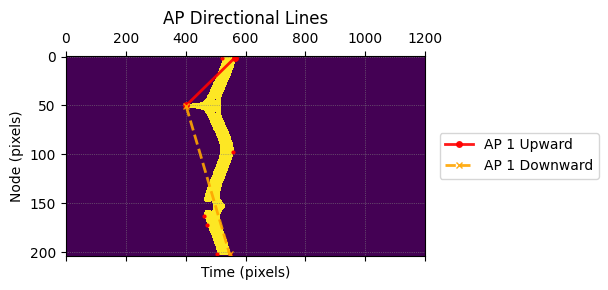


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 565
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (547,202) (Line End Time: 547)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 1.57 mA, Pulse Width 0.76 ms, Delay 1.26


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 145.19it/s]


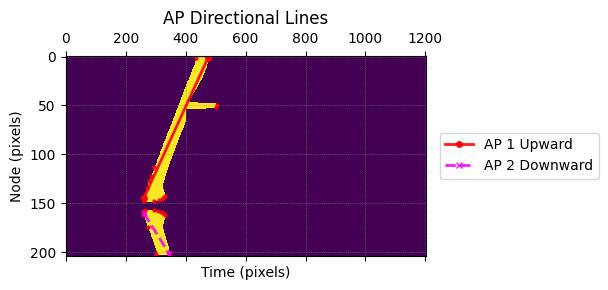


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 260, Overall Component End Time: 503
    Initial Y Extent: Min=145, Max=147
    Upward Line: from (260,145) to (475,1) (Line End Time: 475)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 2):
    Component Start Time: 260, Overall Component End Time: 346
    Initial Y Extent: Min=159, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (260,160) to (346,202) (Line End Time: 346)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude -3.78 mA, Pulse Width 1.78 ms, Delay 0.50


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 142.50it/s]


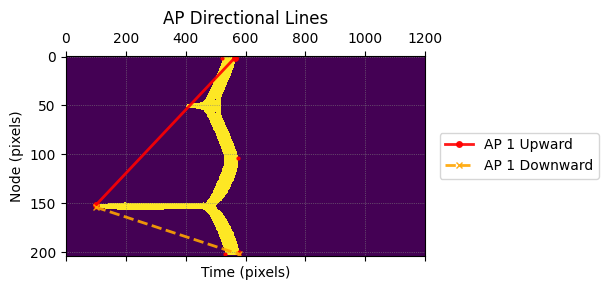


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 100, Overall Component End Time: 578
    Initial Y Extent: Min=152, Max=154
    Upward Line: from (100,152) to (565,1) (Line End Time: 565)
    Downward Line: from (100,154) to (578,202) (Line End Time: 578)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 2.57 mA, Pulse Width 0.22 ms, Delay 1.85


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 149.75it/s]


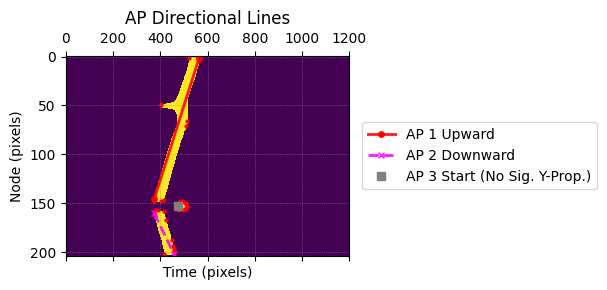


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 374, Overall Component End Time: 565
    Initial Y Extent: Min=146, Max=147
    Upward Line: from (374,146) to (565,1) (Line End Time: 565)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 3):
    Component Start Time: 374, Overall Component End Time: 458
    Initial Y Extent: Min=158, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (374,160) to (458,202) (Line End Time: 458)
  AP 3 (Label: 2):
    Component Start Time: 476, Overall Component End Time: 512
    Initial Y Extent: Min=151, Max=155
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 1.84 mA, Pulse Width 0.79 ms, Delay 1.18


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 140.75it/s]


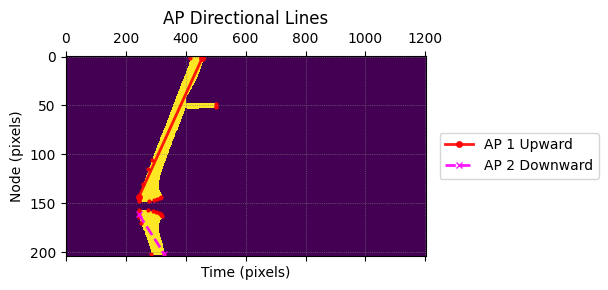


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 243, Overall Component End Time: 502
    Initial Y Extent: Min=144, Max=147
    Upward Line: from (243,144) to (456,1) (Line End Time: 456)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 2):
    Component Start Time: 243, Overall Component End Time: 329
    Initial Y Extent: Min=158, Max=161
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (243,161) to (329,202) (Line End Time: 329)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 1.84 mA, Pulse Width 0.57 ms, Delay 2.29


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 142.60it/s]


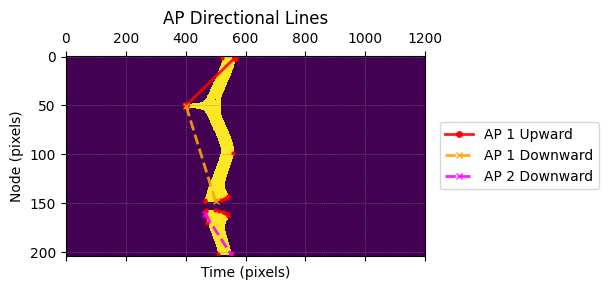


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 565
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (500,148) (Line End Time: 500)
  AP 2 (Label: 2):
    Component Start Time: 465, Overall Component End Time: 551
    Initial Y Extent: Min=158, Max=161
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (465,161) to (551,202) (Line End Time: 551)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude -3.81 mA, Pulse Width 2.80 ms, Delay 2.26


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 144.42it/s]


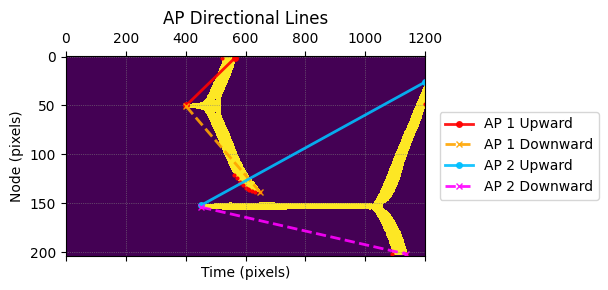


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 647
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (566,1) (Line End Time: 566)
    Downward Line: from (402,51) to (647,138) (Line End Time: 647)
  AP 2 (Label: 2):
    Component Start Time: 452, Overall Component End Time: 1200
    Initial Y Extent: Min=152, Max=154
    Upward Line: from (452,152) to (1200,26) (Line End Time: 1200)
    Downward Line: from (452,154) to (1137,202) (Line End Time: 1137)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude 0.65 mA, Pulse Width 1.82 ms, Delay 1.96


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 145.17it/s]


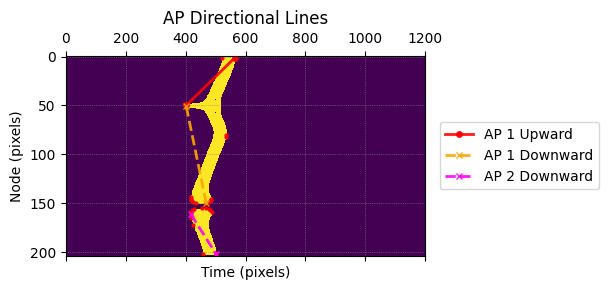


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 565
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (469,150) (Line End Time: 469)
  AP 2 (Label: 2):
    Component Start Time: 417, Overall Component End Time: 502
    Initial Y Extent: Min=161, Max=161
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (417,161) to (502,202) (Line End Time: 502)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}
Configuration: Amplitude -1.75 mA, Pulse Width 2.27 ms, Delay 1.35


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 141.73it/s]


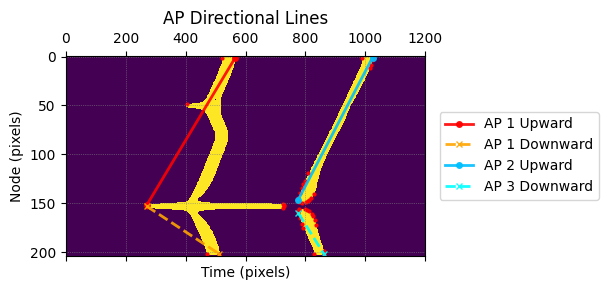


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 270, Overall Component End Time: 727
    Initial Y Extent: Min=152, Max=153
    Upward Line: from (270,152) to (566,1) (Line End Time: 566)
    Downward Line: from (270,153) to (513,202) (Line End Time: 513)
  AP 2 (Label: 2):
    Component Start Time: 775, Overall Component End Time: 1024
    Initial Y Extent: Min=147, Max=147
    Upward Line: from (775,147) to (1024,1) (Line End Time: 1024)
    Downward Line: None (No significant downward propagation detected)
  AP 3 (Label: 3):
    Component Start Time: 776, Overall Component End Time: 862
    Initial Y Extent: Min=158, Max=160
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (776,160) to (862,202) (Line End Time: 862)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 2, 'blockside_aps': 2}}
Configuration: Amplitude 3.97 mA, Pulse Width 0.31 ms, Delay 1.32


5.5 ms: 100%|██████████| 1200/1200 [00:08<00:00, 137.23it/s]


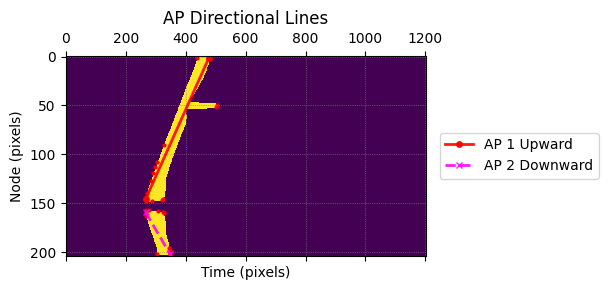


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 266, Overall Component End Time: 503
    Initial Y Extent: Min=146, Max=148
    Upward Line: from (266,146) to (478,1) (Line End Time: 478)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 2):
    Component Start Time: 266, Overall Component End Time: 348
    Initial Y Extent: Min=157, Max=159
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (266,159) to (348,202) (Line End Time: 348)
{'stim_generated': True, 'stim_blocked': False, 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 1}}


In [16]:
# Compute obvervations of for the initial amount of samples
observations = nerve_conduction_blocking_objective(mrg, 
                                                   block_amp = qp[:,0],
                                                   block_pw = qp[:,1],
                                                   block_delay = qp[:,2])

## Meta-model creation

In [17]:
from trieste.acquisition.interface import SingleModelAcquisitionBuilder
from trieste.types import TensorType
from tensorflow_probability import distributions as tfd
from trieste.models.interfaces import ProbabilisticModel


In [18]:
class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset='CONSTRAINT'):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean

        return acquisition
    
    
class BinaryEntropyAcquisition(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model,  dataset: Dataset | None = None):
        def acquisition(at: TensorType) -> TensorType:
            mean, var = model.predict(at)  # Shape: [N, 1]
            
            # Sigmoid / log-reg formula for entropy
            probs = tf.math.sigmoid(mean)
            entropy = -probs * tf.math.log(probs + 1e-6) - (1 - probs) * tf.math.log(1 - probs + 1e-6)

            return tf.squeeze(entropy, axis=-1)
        
        return acquisition

class BinaryEntropyAcquisitionDistibution(SingleModelAcquisitionBuilder[ProbabilisticModel]):
    def prepare_acquisition_function(self, model,  dataset: Dataset | None = None):
        def acquisition(at: TensorType) -> TensorType:
            mean, var = model.predict(at)
            stddev = tf.sqrt(var)

            # Approximate class probs by integrating over latent uncertainty (logit-normal approx)
            normal = tfd.Normal(loc=mean, scale=stddev)
            probs = normal.cdf(0.)  # approximate class 1 probability for threshold at 0

            # Compute entropy
            entropy = -probs * tf.math.log(probs + 1e-6) - (1 - probs) * tf.math.log(1 - probs + 1e-6)
            return tf.squeeze(entropy, axis=-1)
        
        return acquisition
    

class SmoothMinDistanceAcquisition(SingleModelAcquisitionBuilder):
    """
    An acquisition function that promotes sampling diversity by favoring points
    that are far from existing data. It computes a smooth, differentiable
    approximation of the "minimum distance" to the dataset, making it highly
    effective with gradient-based optimizers.

    The goal is to MAXIMIZE the output of this function.
    """
    def __init__(self, temperature: float = 0.01):
        """
        :param temperature: A small positive value that controls the smoothness
                            of the minimum approximation. Smaller values result
                            in a closer approximation to the true 'min' function
                            but can be less numerically stable. A value like 0.01
                            is a robust starting point.
        """
        if temperature <= 0:
            raise ValueError(f"Temperature must be positive, but got {temperature}")
        self.temperature = temperature

    def prepare_acquisition_function(self,
                                     model,  # Not used by this function, but required by the interface.
                                     dataset: Dataset | None = None):
        """
        Prepares the acquisition function. This method is called by the
        acquisition rule, which provides the current model and dataset.
        """
        if dataset is None:
            raise ValueError("SmoothMinDistanceAcquisition requires a dataset to be provided.")
            
        # Ensure the existing points are a tf.constant
        existing_points = tf.constant(dataset.query_points, dtype=tf.float64)

        def acquisition(at: TensorType) -> TensorType:
            """
            Calculates a smooth approximation of the minimum distance from
            candidate points to the existing data points.

            :param at: Candidate points with shape [B, N, D], where B is the
                       batch size, N is the number of candidates per batch,
                       and D is the dimensionality of the search space.
                       The optimizer typically sends points with shape [1, 1, D].
            :return: The smooth minimum distance score for each candidate point,
                     with shape [B, N].
            """
            # Reshape `at` to [B*N, D] for vectorized distance calculations.
            candidate_points = tf.reshape(at, [-1, tf.shape(at)[-1]])
            
            # --- Step 1: Calculate all pairwise squared distances ---
            # We use broadcasting to efficiently compute differences.
            # Shape of expanded_candidates: [M, 1, D] (where M = B*N)
            # Shape of expanded_existing:  [1, K, D] (where K is num of existing points)
            expanded_candidates = tf.expand_dims(candidate_points, 1)
            expanded_existing = tf.expand_dims(existing_points, 0)
            
            # Broadcasting subtraction results in a tensor of shape [M, K, D]
            # containing all difference vectors.
            differences = expanded_candidates - expanded_existing
            
            # Calculate squared Euclidean distances. This is more efficient than
            # using sqrt and sufficient for finding the maximum.
            # The result is a tensor of shape [M, K].
            squared_distances = tf.reduce_sum(tf.square(differences), axis=-1)
            
            # --- Step 2: Use the LogSumExp trick for a smooth minimum ---
            # The formula for a smooth minimum of a set of values {d_i} is:
            #   soft_min({d_i}) = -T * log( sum( exp(-d_i / T) ) )
            # where T is the temperature. This function is differentiable.
            
            # We apply this to our squared distances.
            negative_sq_distances = -squared_distances
            
            # This is the core LogSumExp operation. It computes log(sum(exp(x))).
            log_sum_exp = tf.reduce_logsumexp(negative_sq_distances / self.temperature, axis=1)
            
            # This gives a smooth approximation of max(-d_i^2)
            soft_max_of_neg_dist = self.temperature * log_sum_exp
            
            # Negating the result gives a smooth approximation of min(d_i^2)
            soft_min_sq_distances = -soft_max_of_neg_dist
            
            # Reshape the final result back to the expected [B, N] format
            # for the acquisition rule.
            return tf.reshape(soft_min_sq_distances, tf.shape(at)[:-1])

        return acquisition


In [ ]:
# Create initial dataset (set query point in minmax)
obs_label = np.array([o['stim_blocked'] for o in observations]).reshape(-1,1)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': True,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
    'kernel_variance': None
}
problem_type = 'classification'

online_model = online_learning.build_model(init_dataset, search_space, model_config,
                                           problem_type=problem_type)

# Set up acquisition function and rule
if model_config['classification']:
    acq = BayesianActiveLearningByDisagreement()
    acq = BinaryEntropyAcquisition()
else:
    acq = BinaryEntropyAcquisitionDistibution()


In [55]:

acq = SmoothMinDistanceAcquisition()

rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)


In [25]:

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [56]:
xi = np.linspace(scaler.feature_min[0], scaler.feature_max[0], 50)
yi = np.linspace(scaler.feature_min[1], scaler.feature_max[1], 50)
zi = np.linspace(scaler.feature_min[2], scaler.feature_max[2], 50)

X_grid, Y_grid = np.meshgrid(xi, yi)

z_slice_val = np.median([scaler.feature_min[2], scaler.feature_max[2]]) 
grid_points = np.hstack([X_grid.reshape(-1, 1), 
                         Y_grid.reshape(-1, 1), 
                         np.full((X_grid.size, 1), z_slice_val)])

grid_points_minmax = scaler.transform(grid_points)
acquisition_function = acq.prepare_acquisition_function(ask_tell.model, dataset= init_dataset)
grid_points_tensor = tf.cast(grid_points_minmax, tf.float64)
def evaluate_on_single_point(point):
    # point has shape [D] (e.g., [3])
    # Reshape it to [1, 1, D] for the acquisition function
    point_reshaped = tf.reshape(point, [1, 1, -1])
    # Call the function and squeeze the result back to a scalar
    return tf.squeeze(acquisition_function(point_reshaped))

#acq_vals_on_grid = tf.map_fn(evaluate_on_single_point, grid_points_tensor, fn_output_signature=tf.float64).numpy()
#Z = acq_vals_on_grid.reshape(X_grid.shape)


In [57]:
acquisition_function = acq.prepare_acquisition_function(ask_tell.model, dataset=init_dataset)
Z = acquisition_function(grid_points_tensor).numpy().reshape(X_grid.shape)

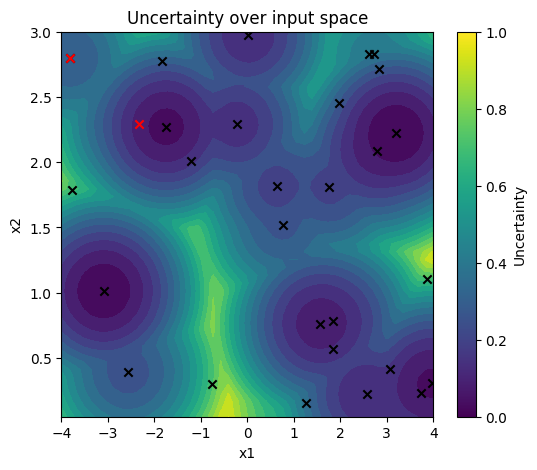

In [58]:
# Plot
X = scaler.inverse_transform(init_dataset.query_points)
y = init_dataset.observations.numpy().squeeze()
plt.figure(figsize=(6, 5))
plt.contourf(X_grid, Y_grid, Z, levels=20, cmap='viridis')

plt.scatter(X[y==0,0],X[y==0,1],c='k',marker='x')
plt.scatter(X[y==1,0],X[y==1,1],c='r',marker='x')

plt.colorbar(label="Uncertainty")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Uncertainty over input space")
plt.show()

Configuration: Amplitude -3.88 mA, Pulse Width 2.80 ms, Delay 2.11


5.5 ms: 100%|██████████| 1200/1200 [00:07<00:00, 167.25it/s]


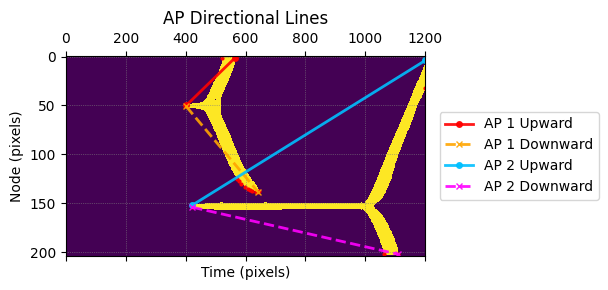


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 644
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (566,1) (Line End Time: 566)
    Downward Line: from (402,51) to (641,138) (Line End Time: 641)
  AP 2 (Label: 2):
    Component Start Time: 422, Overall Component End Time: 1200
    Initial Y Extent: Min=152, Max=154
    Upward Line: from (422,152) to (1200,4) (Line End Time: 1200)
    Downward Line: from (422,154) to (1108,202) (Line End Time: 1108)
{'stim_generated': True, 'stim_blocked': True, 'debug_info': {'num_aps_gen_side': 2, 'blockside_aps': 1}}
Abort is in progress...hit ctrl-c again within 5 seconds to forcibly terminate



AssertionError: Concurrent access?

In [29]:
# Optimization loop as for a next point to query
max_iters = 30  # Increase the number of iterations as needed
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")
    # Run the simulation and get observations
    observations_new = nerve_conduction_blocking_objective(mrg, 
                                                           block_amp = qp_new[:,0],
                                                           block_pw = qp_new[:,1],
                                                           block_delay = qp_new[:,2])
    obs_label = [o['stim_blocked'] for o in observations_new]
    obs_label = np.array(obs_label)
    if obs_label.ndim == 1:
        obs_label = obs_label.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

    # Interpolate scalar uncertainty values
    acq_vals_on_grid = tf.map_fn(evaluate_on_single_point, grid_points_tensor, fn_output_signature=tf.float64).numpy()
    Z = acq_vals_on_grid.reshape(X_grid.shape)

    new_samples = scaler.inverse_transform(ask_tell.datasets['OBJECTIVE'].query_points.numpy())
    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X_grid, Y_grid, Z.squeeze(), levels=20, cmap='viridis')
    plt.scatter(X[:,0],X[:,1],c='k',marker='x')
    plt.scatter(new_samples[len(X):,0], new_samples[len(X):,1],c='red',marker='o')
    plt.scatter(qp_new[:,0], qp_new[:,1],c='k',marker='*')
    plt.colorbar(label="Uncertainty")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Entropy over input space ~ before update")
    plt.show()
    
    preds, _ = ask_tell.model.predict(init_dataset.query_points)
    
# Save results
#ask_tell.save()

In [229]:
# Concatenate all data
#all_qp_array = np.vstack(all_qp)
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['block_amp', 'block_pw', 'block_delay'])
df['sample_type'] = all_sample_types_array
df = pd.concat([df, df_all_observations],axis=1)
# Map 'ap_count' to labels
#df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

In [230]:
init_samples

30

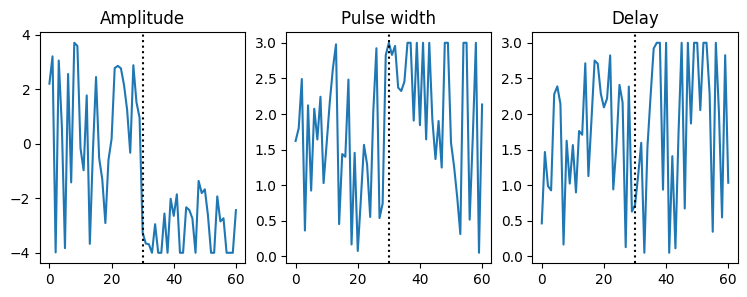

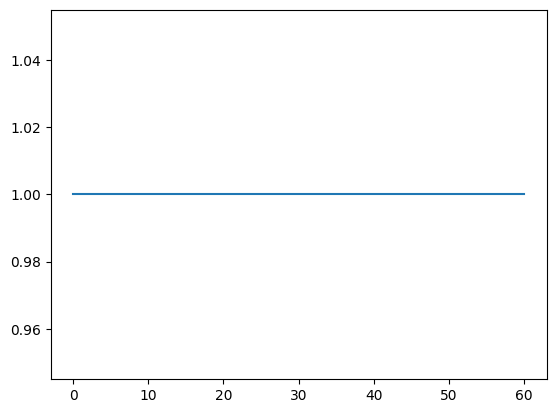

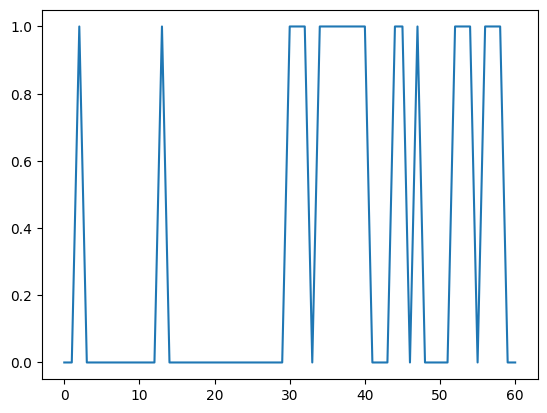

In [231]:
fig, ax = plt.subplots(ncols=3, figsize=(9,3))
ax = ax.ravel()
df['block_amp'].plot(ax=ax[0])
df['block_pw'].plot(ax=ax[1])
df['block_delay'].plot(ax=ax[2])
ax[0].set_title("Amplitude")
ax[1].set_title("Pulse width")
ax[2].set_title("Delay")
ax[0].axvline(init_samples, linestyle=':',c='k')
ax[1].axvline(init_samples, linestyle=':',c='k')
ax[2].axvline(init_samples, linestyle=':',c='k')

plt.figure()
plt.plot(df['stim_generated'])
plt.show()

plt.figure()
plt.plot(df['stim_blocked'])
plt.show()

In [232]:
df[df['stim_blocked']]

,block_amp,block_pw,block_delay,sample_type,stim_generated,stim_blocked,debug_info
2,-3.986311,2.490693,0.986376,Initial,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
13,-3.672277,2.978014,1.707659,Initial,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
30,-3.265402,3.000000,0.721043,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
31,-3.660294,2.829856,1.133876,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
32,-3.688318,2.956267,1.594122,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
34,-2.950852,2.322949,1.537982,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
35,-4.000000,2.453873,2.247333,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
36,-4.000000,3.000000,2.919680,Optimization,True,True,"{'num_aps_gen_side': 1, 'blockside_aps': 0}"
37,-2.559389,3.000000,3.000000,Optimization,True,True,"{'num_aps_gen_side': 1, 'blockside_aps': 0}"
38,-4.000000,1.907143,3.000000,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"


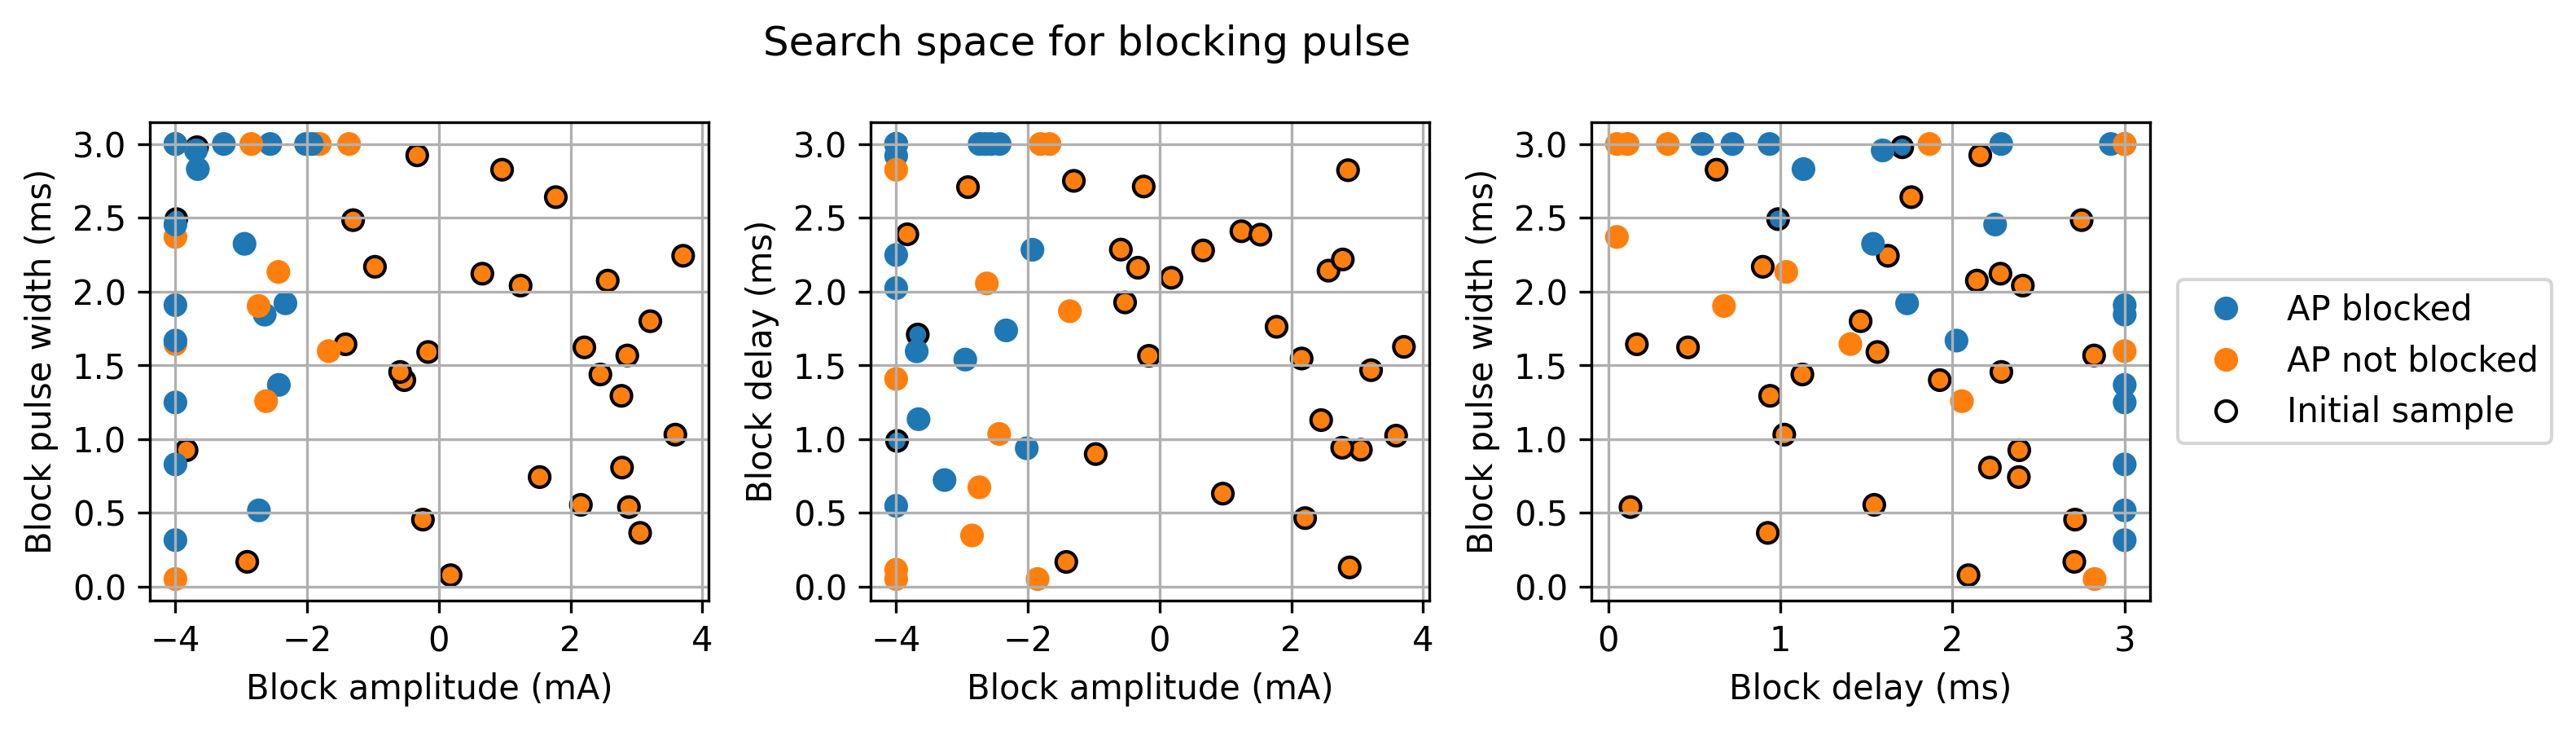

In [233]:
fig, ax = plt.subplots(ncols=3, figsize=(9,3), dpi=300)
col_map = {True:'C0',False:'C1'}
edgecolors = [
    'k' if t == 'Initial' else col_map[b] 
    for t, b in zip(df['sample_type'], df['stim_blocked'])
]
colors = [col_map[c] for c in df['stim_blocked']]

ax[0].scatter(df['block_amp'], df['block_pw'], 
              c=colors, 
              edgecolors=edgecolors)
ax[1].scatter(df['block_amp'], df['block_delay'],
              c=colors,
              edgecolors=edgecolors)
ax[2].scatter(df['block_delay'], df['block_pw'],
              c=colors,
              edgecolors=edgecolors)

ax[0].set_xlabel("Block amplitude (mA)")
ax[1].set_xlabel("Block amplitude (mA)")
ax[2].set_xlabel("Block delay (ms)")

ax[0].set_ylabel("Block pulse width (ms)")
ax[1].set_ylabel("Block delay (ms)")
ax[2].set_ylabel("Block pulse width (ms)")

ax[0].grid()
ax[1].grid()
ax[2].grid()

fig.suptitle("Search space for blocking pulse")
#fig.tight_layout(rect=[0, 0, 0.85, 0.95])  # leave space for legend on the right
fig.tight_layout()
legend_handles = [
    mlines.Line2D([], [], color='C0', marker='o', linestyle='None', label='AP blocked'),
    mlines.Line2D([], [], color='C1', marker='o', linestyle='None', label='AP not blocked'),
    mlines.Line2D([], [], color='k', marker='o', markerfacecolor='white', linestyle='None', label='Initial sample')
]
ax[2].legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)


In [234]:
df.sort_values(axis=0, by='stim_blocked').head(10)


,block_amp,block_pw,block_delay,sample_type,stim_generated,stim_blocked,debug_info
0,2.208555,1.620918,0.463026,Initial,True,False,"{'num_aps_gen_side': 2, 'blockside_aps': 2}"
23,2.771437,1.292214,0.940083,Initial,True,False,"{'num_aps_gen_side': 1, 'blockside_aps': 1}"
24,2.155782,0.552871,1.545212,Initial,True,False,"{'num_aps_gen_side': 1, 'blockside_aps': 1}"
25,1.240978,2.039775,2.408361,Initial,True,False,"{'num_aps_gen_side': 1, 'blockside_aps': 2}"
26,-0.328803,2.923246,2.161003,Initial,True,False,"{'num_aps_gen_side': 1, 'blockside_aps': 1}"
27,2.885106,0.537963,0.128702,Initial,True,False,"{'num_aps_gen_side': 2, 'blockside_aps': 2}"
28,1.529667,0.741154,2.385105,Initial,True,False,"{'num_aps_gen_side': 1, 'blockside_aps': 1}"
29,0.959456,2.825599,0.628946,Initial,True,False,"{'num_aps_gen_side': 2, 'blockside_aps': 2}"
59,-4.000000,0.050000,2.825447,Optimization,True,False,"{'num_aps_gen_side': 1, 'blockside_aps': 1}"
22,2.860199,1.565807,2.822403,Initial,True,False,"{'num_aps_gen_side': 1, 'blockside_aps': 1}"


In [166]:
top_blocked = df[df['stim_blocked'] & (df['sample_type']=='Optimization')].sort_values(by='block_amp')
top_blocked

,block_amp,block_pw,block_delay,sample_type,stim_generated,stim_blocked,debug_info
35,-4.000000,2.414606,2.227415,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
36,-4.000000,3.000000,2.906359,Optimization,True,True,"{'num_aps_gen_side': 1, 'blockside_aps': 0}"
57,-4.000000,3.000000,0.476457,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
38,-4.000000,1.902298,3.000000,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
55,-4.000000,0.402961,3.000000,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
44,-4.000000,1.334997,3.000000,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
51,-4.000000,0.910000,3.000000,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
47,-4.000000,1.644422,1.876020,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
32,-3.688344,2.956238,1.594135,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"
31,-3.660288,2.829865,1.133897,Optimization,True,True,"{'num_aps_gen_side': 2, 'blockside_aps': 1}"


In [167]:
top_blocked['debug_info'].values

array([{'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 1, 'blockside_aps': 0},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 1, 'blockside_aps': 0},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num_aps_gen_side': 2, 'blockside_aps': 1},
       {'num

## Example of blocking configuration

In [168]:
mrg = create_mrg(diameter=27, length=120, v_init=-80, verbose=True)

# Here we use a fixed stimulation pulse parameters that we want to block
# The stimulation pulse to block start after 1 ms
stim_amp = -1.00 #* mA
stim_pw = 0.50 #* ms
stim_delay = 2.0 #* ms

new_block_params = top_blocked.iloc[-1]  # You can also use np.random.choice to pick randomly
#new_block_params = df.iloc[0]

# Assign new values for stimulation blocking
block_amp = new_block_params['block_amp'] * mA 
block_pw = new_block_params['block_pw'] * ms 
block_delay = new_block_params['block_delay'] * ms 

# Create stimuli (a stim and block pulse)
stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

# Create electrodes at both sides of origin (spacing 60 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y=-30 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=30 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors avoid monitoring the edges to eliminate boundary conditions
ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim,
                electrode_block],
    monitors=[
        v_rec,
        ap_monitor_end,
        ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 6 * ms, progressbar=True, early_stopping=False)

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


5.5 ms: 100%|██████████| 1200/1200 [00:21<00:00, 55.46it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 2
  dt: 0.005 ms

In [169]:
stim, block

(Scale:1 :: MonophasicPulse {'amp': '-1.0', 'pw': '0.5 ms', 'delay': '2.0 ms', 'offset': '0'},
 Scale:1 :: MonophasicPulse {'amp': '-2.0231685341196277 mA', 'pw': '3.0 ms', 'delay': '0.8564189103578642 ms', 'offset': '0'})

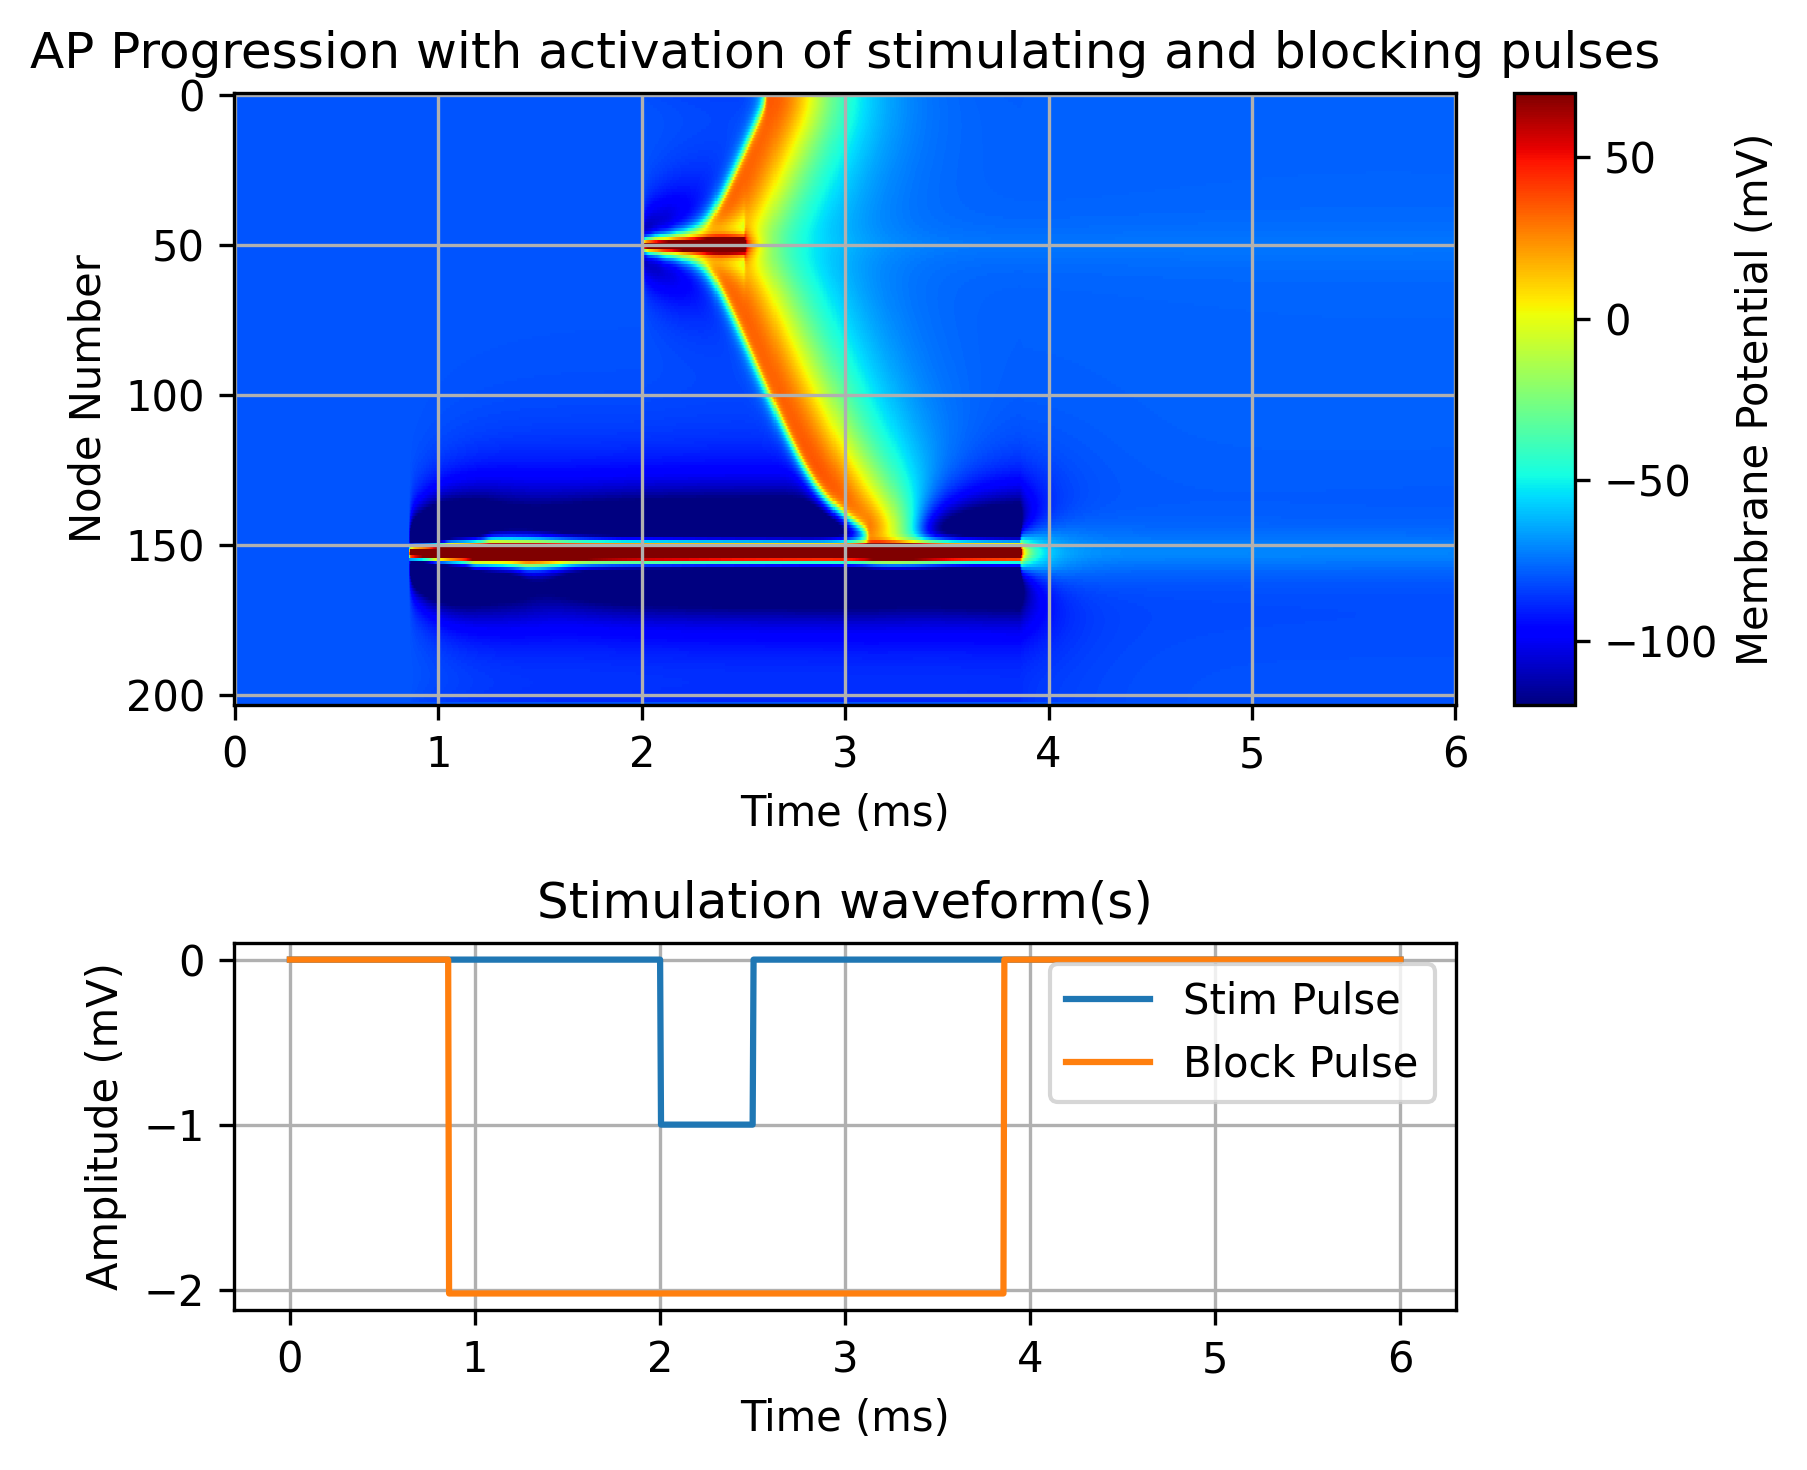

In [170]:
fig = plt.figure(figsize=(6,5), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[20, 1], height_ratios=[1, 0.6], figure=fig)

# Create the two axes and one for colorbar
ax0 = fig.add_subplot(gs[0, 0])  # Main AP plot
ax1 = fig.add_subplot(gs[1, 0])  # Waveform plot
cax = fig.add_subplot(gs[0, 1])  # Colorbar axis

# Plot the AP progression on the first axis
plot_progression_AP_2D(mrg, v_rec, with_cbar=False, ax=ax0)
#
im = ax0.collections[0]  # the QuadMesh from pcolormesh
fig.colorbar(im, cax=cax, label='Membrane Potential (mV)')


# Plot both waveforms on the same second axis (overlaid)
plot_waveform(stim, v_rec, label='Stim Pulse', ax=ax1)
plot_waveform(block, v_rec, label='Block Pulse', ax=ax1)
#ax1.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
#fig.subplots_adjust(right=0.8)
#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)

ax1.grid()
fig.tight_layout()

In [ ]:
nerve_block_condition(ap_monitor_left=ap_monitor_start, ap_monitor_right=ap_monitor_end)

Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: []
AP IS BLOCKED!!


0

In [ ]:
v_bool = (v_rec.v > -0.20).astype(int)

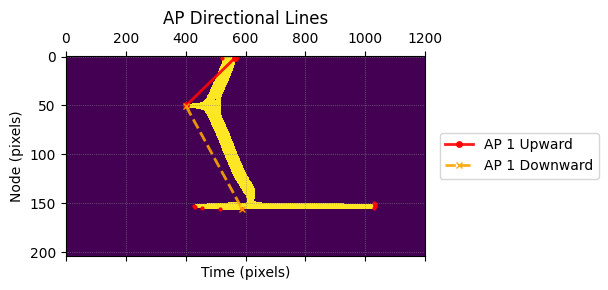


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 1032
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (566,1) (Line End Time: 566)
    Downward Line: from (402,51) to (589,156) (Line End Time: 589)


In [ ]:
ap_directional_lines = get_ap_directional(v_bool, min_nodes_for_ap_start=1, y_propagation_threshold=5)
plot_directional_aps(ap_directional_lines=ap_directional_lines, v_bool=v_bool)



In [ ]:
detect_block_naive(block_delay, ap_directional_lines=ap_directional_lines,v_rec=v_rec)

{'stim_generated': True,
 'stim_blocked': True,
 'debug_info': {'num_aps_gen_side': 1, 'blockside_aps': 0}}